In [55]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns

In [24]:
# PREPROCESSING FUNCTIONS


# Helper Functions
def split_external_data(df):
    """
    df_uml = training data
    df_umg = external validation set
    note: external validation set is different from the test data from train test split
    """
    groups = df.groupby(by = 'Center')
    df_uml = groups.get_group('Leipzig')
    df_umg = groups.get_group('Greifswald')

    return df_uml, df_umg

def undersample_data(df):
    print(f'Count of each target variable before undersampling: {df['Diagnosis'].value_counts()}')

    groups = df.groupby(by = 'Diagnosis')
    sep = groups.get_group(1)
    ctrl = groups.get_group(0)

    rows = sep.shape[0]
    ctrl = ctrl.sample(n=rows, random_state=42)

    df = pd.concat([ctrl, sep], axis=0, ignore_index=True)
    df = df.copy()
    print(f'Count of each target variable after undersampling: {df['Diagnosis'].value_counts()}')

    return df

def rescale_dataset(df):
    df = df.copy()
    # print(f'Count of each target variable before rescaling: {df['Diagnosis'].value_counts()}')
    
    X_df = df.drop(columns=['Diagnosis'])
    y = df['Diagnosis']

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_df)
    X_df = pd.DataFrame(X, columns=X_df.columns)
    joblib.dump(scaler, 'scaler.pkl')

    # print(f'Index check before adding Diagnosis: {X_df.index.equals(y.index)}')

    X_df = X_df.reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_df['Diagnosis'] = y

  
    # After scaling
    print(f'Length of X_df after scaling: {len(X_df)}')


    print(f'Count of each target variable after rescaling: {X_df['Diagnosis'].value_counts()}')

    return X_df

def remove_outliers(df):
    #remove target
    X_df = df.drop(columns=['Diagnosis'])

    # get iqr
    q1 = X_df.quantile(0.25)
    q3 = X_df.quantile(0.75)
    iqr = q3 - q1

    # get bounds for dataset
    low_bound = q1 - 1.5 * iqr
    upp_bound = q3 + 1.5 * iqr

    #get index of non outliers
    non_outlier_boolean = ((X_df >= low_bound) & (X_df <= upp_bound)).all(axis=1)
    non_outlier_index = non_outlier_boolean[non_outlier_boolean].index

    # extract non outliers
    df = df.loc[non_outlier_index]
    print(f'Count of each target variable after outlier removal: {df['Diagnosis'].value_counts()}')

    return df



def clean(df):
    df = df.copy()

    # numeric encoding
    df['Sex'] = pd.factorize(df['Sex'])[0]
    df['Diagnosis'] = pd.factorize(df['Diagnosis'])[0]

    # Remove SIRS diagnosis
    df['Diagnosis'] = df['Diagnosis'][df['Diagnosis'] !=2]
    print(f'Count of each target variable before preprop: {df['Diagnosis'].value_counts()}')

    # Drop extraneous columns
    df = df.drop(columns=['Id','Center', 'Set', 'Sender', 'Episode', 'Time','TargetIcu', 'SecToIcu','PCT', 'CRP'])

    # remove duplicates and NA
    df = df.drop_duplicates()
    df.dropna(inplace=True)
    print(f'Count of each target variable after dropping na and duplicates: {df['Diagnosis'].value_counts()}')

    
    return df


In [25]:
# Main Function
def preprocess(df, save_csv = False):
    df = df.copy()
    datasets = split_external_data(df)

    preprops = []
    for df in datasets:
        df = clean(df)
        df = remove_outliers(df)
        df = rescale_dataset(df)
        df = undersample_data(df)
        preprops.append(df)

    df_uml = preprops[0]
    df_umg = preprops[1]
    # Save preprocessed data if desired
    if save_csv:
        df_uml.to_csv('sbcdata_preprocessed_training.csv', index=False)
        df_umg.to_csv('sbcdata_preprocessed_external_val.csv', index=False)

    preprops = tuple(preprops)
    return preprops





In [26]:
# PREPROCESS DATA
file_path = r'G:\My Drive\School\Current Classes\SSIE 548 - Healtchare Data Science\Project\Data\sbcdata.csv'
df = pd.read_csv(file_path)

#if you want the files to be saved set save_csv to true
df_uml, df_umg = preprocess(df, save_csv=False)



Count of each target variable before preprop: Diagnosis
0.0    1776380
1.0     251395
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Count of each target variable after outlier removal: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Length of X_df after scaling: 1706171
Count of each target variable after rescaling: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Count of each target variable before undersampling: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Count of each target variable after undersampling: Diagnosis
0.0    184955
1.0    184955
Name: count, dtype: int64
Count of each target variable before preprop: Diagnosis
0.0    526943
1.0    128578
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    513133
1.0    122511
Name: count, dtype: int64
Count of each tar

In [27]:
# confirm preprocessing worked

print('training set preprocessing confirmation')
display(df_uml.Diagnosis.value_counts()) #make sure data is balance
display(df_uml)

print('validation set preprocessing confirmation')

display(df_umg.Diagnosis.value_counts()) #make sure data is balance
display(df_umg)

training set preprocessing confirmation


Diagnosis
0.0    184955
1.0    184955
Name: count, dtype: int64

,Age,Sex,HGB,MCV,PLT,RBC,WBC,Diagnosis
0,0.363636,1.0,0.598131,0.802083,0.463710,0.524306,0.536313,0.0
1,0.056818,0.0,0.560748,0.409722,0.725806,0.579861,0.312849,0.0
2,0.636364,0.0,0.682243,0.628472,0.354839,0.685764,0.357542,0.0
3,0.193182,0.0,0.495327,0.506944,0.895161,0.498264,0.530726,0.0
4,0.056818,0.0,0.850467,0.361111,0.413306,0.821181,0.318436,0.0
...,...,...,...,...,...,...,...,...
369905,0.431818,0.0,0.392523,0.760417,0.268145,0.329861,0.558659,1.0
369906,0.431818,0.0,0.271028,0.843750,0.135081,0.217014,0.217877,1.0
369907,0.431818,0.0,0.401869,0.788194,0.221774,0.342014,0.458101,1.0
369908,0.431818,0.0,0.355140,0.840278,0.211694,0.298611,0.374302,1.0


validation set preprocessing confirmation


Diagnosis
0.0    100802
1.0    100802
Name: count, dtype: int64

,Age,Sex,HGB,MCV,PLT,RBC,WBC,Diagnosis
0,0.646341,0.0,0.435644,0.824324,0.472803,0.392157,0.586387,0.0
1,0.780488,1.0,0.653465,0.456081,0.648536,0.647059,0.905759,0.0
2,0.634146,1.0,0.544554,0.824324,0.317992,0.450980,0.381675,0.0
3,0.731707,1.0,0.366337,0.523649,0.215481,0.352941,0.575916,0.0
4,0.536585,1.0,0.485149,0.300676,0.271967,0.509804,0.806283,0.0
...,...,...,...,...,...,...,...,...
201599,0.560976,0.0,0.445545,0.476351,0.594142,0.450980,0.586387,1.0
201600,0.560976,0.0,0.405941,0.486486,0.656904,0.411765,0.460209,1.0
201601,0.524390,1.0,0.564356,0.520270,0.361925,0.549020,0.753927,1.0
201602,0.524390,1.0,0.485149,0.550676,0.257322,0.470588,0.994764,1.0


In [67]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# model = KNeighborsClassifier(n_neighbors=13, metric='manhattan')
model = xgb.XGBClassifier()

X = df_uml.drop(columns=['Diagnosis'])
y = df_uml['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics = {
"accuracy": accuracy_score(y_test, y_pred),
"precision": precision_score(y_test, y_pred, average="weighted"),
"recall": recall_score(y_test, y_pred, average="weighted"),
"f1_score": f1_score(y_test, y_pred, average="weighted"),
"confusion_matrix": confusion_matrix(y_test, y_pred),
"roc_auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], multi_class="ovr", average="weighted"),
"model" : model

}

metrics

{'accuracy': 0.8066286393987727,
 'precision': np.float64(0.8086036975365718),
 'recall': np.float64(0.8066286393987727),
 'f1_score': np.float64(0.8063359276088805),
 'confusion_matrix': array([[28431,  8623],
        [ 5683, 31245]]),
 'roc_auc': np.float64(0.8876061999576897),
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
    

In [68]:
metrics['model']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
X = df_umg.drop(columns=['Diagnosis'])
y_test = df_umg['Diagnosis']
y_pred = model.predict(X)

metrics = {
"accuracy": accuracy_score(y_test, y_pred),
"precision": precision_score(y_test, y_pred, average="weighted"),
"recall": recall_score(y_test, y_pred, average="weighted"),
"f1_score": f1_score(y_test, y_pred, average="weighted"),
"confusion_matrix": confusion_matrix(y_test, y_pred),
"roc_auc": roc_auc_score(y_test, model.predict_proba(X)[:, 1], multi_class="ovr", average="weighted"),
"model" : model
}

print(metrics)

{'accuracy': 0.7031904128886332, 'precision': np.float64(0.7046310967646398), 'recall': np.float64(0.7031904128886332), 'f1_score': np.float64(0.7026670775378852), 'confusion_matrix': array([[75112, 25690],
       [34148, 66654]]), 'roc_auc': np.float64(0.7684869577098197), 'model': KNeighborsClassifier(metric='manhattan', n_neighbors=13)}


In [65]:
metrics

{'accuracy': 0.7031904128886332,
 'precision': np.float64(0.7046310967646398),
 'recall': np.float64(0.7031904128886332),
 'f1_score': np.float64(0.7026670775378852),
 'confusion_matrix': array([[75112, 25690],
        [34148, 66654]]),
 'roc_auc': np.float64(0.7684869577098197),
 'model': KNeighborsClassifier(metric='manhattan', n_neighbors=13)}

In [30]:
# import joblib
# joblib.dump(model, "xgboost_model.pkl")

In [31]:
# import pickle
# from sklearn.metrics import accuracy_score  # or any relevant metric

# # Load the .pkl model
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')


In [32]:
file_path = r'G:\My Drive\School\Current Classes\SSIE 548 - Healtchare Data Science\Project\Data\sbcdata.csv'
df = pd.read_csv(file_path)
datasets = split_external_data(df)
df = datasets[0]
df = clean(df)
df = remove_outliers(df)
df = rescale_dataset(df)

Count of each target variable before preprop: Diagnosis
0.0    1776380
1.0     251395
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Count of each target variable after outlier removal: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Length of X_df after scaling: 1706171
Count of each target variable after rescaling: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(df1, df2, model):
    """
    Plots the ROC curves for two datasets using the same trained model.

    Parameters:
    df1 : DataFrame
        The first dataset with features and binary target label ('Diagnosis').
    df2 : DataFrame
        The second dataset with features and binary target label ('Diagnosis').
    model_metrics : dict
        A dictionary containing the trained model and associated metrics.
        Example: {'model': trained_model, 'roc_auc': roc_auc_score}
    """

    # Define a helper function to calculate ROC values
    def calculate_roc(df):
        X = df.drop(columns=['Diagnosis'])
        y = df['Diagnosis']
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X)
        else:
            raise ValueError("Model does not have predict_proba or decision_function methods.")
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

    # Calculate ROC for both datasets
    fpr1, tpr1, roc_auc1 = calculate_roc(df1)
    fpr2, tpr2, roc_auc2 = calculate_roc(df2)

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'UML ROC (AUC = {roc_auc1:.3f})')
    plt.plot(fpr2, tpr2, color='orange', lw=2, label=f'UMG ROC (AUC = {roc_auc2:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for XgBoost')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


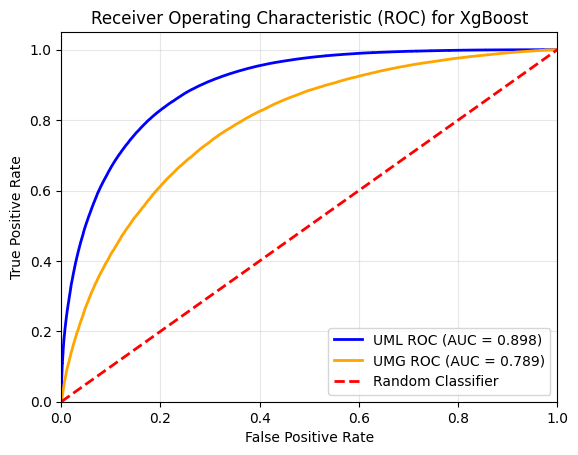

In [53]:
plot_roc_curves(df_uml, df_umg, metrics)


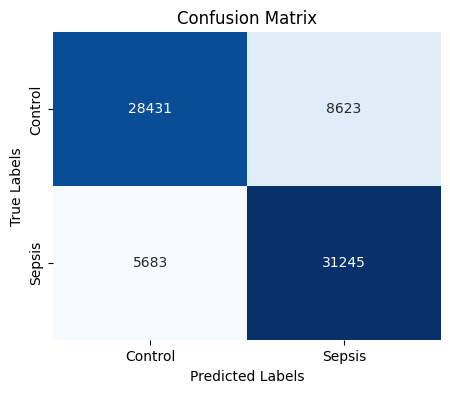

In [56]:
def plot_confusion_matrix(model_metrics):
    cm = model_metrics.get("confusion_matrix")
    class_labels=["Control", "Sepsis"]

    if cm is not None:
        # Plot confusion matrix using seaborn heatmap
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                    xticklabels=class_labels, 
                    yticklabels=class_labels)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()
    else:
        print("Confusion matrix is not available in the model metrics.")

plot_confusion_matrix(metrics)

In [ ]:
file_path = r'G:\My Drive\School\Current Classes\SSIE 548 - Healtchare Data Science\Project\Data\sbcdata.csv'
df = pd.read_csv(file_path)

In [ ]:
df = df.drop(columns=['Id','Center', 'Set', 'Sender', 'Episode', 'Time','TargetIcu', 'SecToIcu','PCT'])


KeyboardInterrupt: 

In [ ]:
plot_roc_curves(df_uml, df_umg, best_knn)